In [71]:
import numpy as np
import random
import matplotlib.pyplot as plt
import enum
import itertools
import operator
import math

%matplotlib inline

In [49]:
@enum.unique
class Grade(enum.IntEnum):
    """
    Represents relevance on a graded scale. 
    Any positive number represents relevance, with higher numbers representing higher relevance (total ordering)
    Zero represents irrelevant
    """
    N = (0)   # Not relevant
    R = (1)   # Relevant
    HR = (2)  # Highly relevant

    
    @property
    def is_relevant(self):
        """
        'Binarizes' the relevance. Useful for computing binary metrics like precision / recall
        """
        return False if self.value == 0 else True
    
    @classmethod
    def from_int_list(cls, int_list):
        """
        Converts a list of integers to a list of Grade
        """
        members = dict((member.value, member) for member in cls.__members__.values())
        return [members[value] for value in int_list]
    def __str__(self):
        return self.name
    
    def __repr__(self):
        return self.name

print(Grade.from_int_list([0, 1, 2]))

[N, R, HR]


In [50]:
def get_all_permutations(grade, sequence_length):
    """
    For a given grade and a sequence length n, returns all possible permutations of length n that can be formed. 
    Note that a generator is returned and not a list
    """
    for i, perm in enumerate(itertools.product(range(len(grade.__members__)), repeat=sequence_length)):
        yield grade.from_int_list(perm)

def get_all_permutation_pairs(grade, sequence_length):
    """
    Generates all possible pairs of permutations given a grade and a sequence length.
    Note that a generator is returned and not a list
    """
    sequence_1 = get_all_permutations(grade, sequence_length)
    sequence_2 = get_all_permutations(grade, sequence_length)    
    for pair in itertools.product(sequence_1, sequence_2):
        p1, p2 = pair
        # don't return exact duplicates
        if all(map(lambda _ : _[0] == _[1], zip(p1, p2))) == True:
            continue
        yield pair

def count_sequence(seq):
    """
    `len` for generators
    """
    count = 0
    for _ in seq:
        count += 1
    return count

# A sanity check to ensure the correct number of sequences are being generated
# the `-(3**5)` removes exact duplicates
assert count_sequence(get_all_permutation_pairs(Grade, 5)) == (3**5) * (3**5) - (3 ** 5)

## Step 1: Simulate Rankings of Relevance for E and P (5 points)

In the first step you will generate pairs of rankings of relevance, for the production P and experimental E, respectively, for a hypothetical query q. Assume a 3-graded relevance, i.e. {N, R, HR}. Construct all possible P and E ranking pairs of length 5. This step should give you about.

Example:

P: {N N N N N}
E: {N N N N R}

…
P: {HR HR HR HR R}
E: {HR HR HR HR HR}

TODO add assumption that we weed out exactly similar documents (or do WE?) dun dun dun

In [51]:
permutations = list(get_all_permutation_pairs(Grade, 5))

In [52]:
permutations[0]

([N, N, N, N, N], [N, N, N, N, R])

In [53]:
permutations[-1]

([HR, HR, HR, HR, HR], [HR, HR, HR, HR, R])

In [54]:
production = list(map(operator.itemgetter(0), permutations))
experiment = list(map(operator.itemgetter(1), permutations))

Single Query Assumption.
We can assume that the entire experiment is for a single query, so there are only 10 R + 10 HR documents i.e a total of 20 relevant documents.

In [55]:
# TODO double check this
relevant_count_production = 20
relevant_count_experiment = 20
(relevant_count_experiment, relevant_count_production)

(20, 20)

## Step 2: Implement Evaluation Measures (10 points)
Implement 1 binary and 2 multi-graded evaluation measures out of the 7 measures mentioned above. 

In [67]:
class Metric:
    def compute(self, results, **kwargs):
        raise NotImplementedError()

class ContigencyTable(Metric):
    def __init__(self):
        self.true_positive = 0
        self.true_negative = 0
        self.false_negative = 0
        self.false_positive = 0
    
    def compute(self, production, experimental):
        for p, e in zip(production, experimental):
            # binarize
            p, e = p.is_relevant, e.is_relevant
            if p == True and e == True:
                self.true_positive += 1
            elif p == True and e == False:
                self.false_negative += 1
            elif p == False and e == True:
                self.false_positive += 1
            else:
                self.false_negative += 1    
        
class Precision(Metric):
    
    @property
    def name(self):
        return "precision"
    
    def compute(self, results, **kwargs):
        # if k is not specified, the entire list is used
        k = kwargs.get("k", len(results))
        
        # only up to k
        results = results[:k]
        # binarize, compute how many are relevant and divide by k
        return sum(r.is_relevant for r in results) / k
    
class Recall(Metric):
    
    @property
    def name(self):
        return "precision"
    
    def compute(self, results, **kwargs):
        assert "relevant_count" in kwargs
        # if k is not specified, the entire list is used
        k = kwargs.get("k", len(production))
        
        # only up to k
        results = results[:k]
        # binarize and count, divide by number of relevant documents
        # the number of relevant documents is a function of the total number of relevant documents
        # and how many *can* be present in a list of length k
        # if there are only k = 5 and total = 20, recall can never be 1 even when the all documents are relevant
        # therefore, the denom should be min(k, total)
        # TODO verify
        return sum(r.is_relevant for r in results) / min(k, kwargs["relevant_count"]) 
        
    
class AveragePrecision(Metric):
    def compute(self, results, **kwargs):
        assert "relevant_count" in kwargs
        P = Precision()
        precisions = np.zeros(len(results))
        for k in range(1, len(results) + 1):
            precisions[k-1] = P.compute(results, k=k)
        # TODO verify
        return precisions.sum() / min(len(results), kwargs["relevant_count"]) 

AP = AveragePrecision()
ap = np.array([AP.compute(r, relevant_count = relevant_count_production) for r in production])
print(ap)

[0. 0. 0. ... 1. 1. 1.]


In [68]:
ap.mean()

0.6666666666666665

In [69]:
ap.max()

1.0

(array([ 1210.,  2420.,  4356.,  2904.,  4356.,  8712.,  2904.,  8712.,
         7744., 15488.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

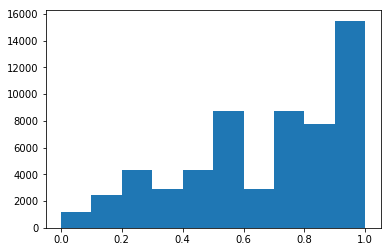

In [70]:
plt.hist(ap)

In [76]:

class DCG(Metric):
    def compute(self, results, **kwargs):
        
        # if k is not specified, the entire list is used
        k = kwargs.get("k", len(production))
        
        # only up to k
        results = results[:k]
        
        dcg = 0.0 
        for rank, result in enumerate(results):
            rank += 1 # TODO verify
            gain = 2**result.value - 1
            discount = math.log2(1 + rank)
            dcg += gain / discount
        return dcg

class NDCG(Metric):
    def compute(self, results, **kwargs):
        max_value = kwargs["max_value"]
        # if k is not specified, the entire list is used
        k = kwargs.get("k", len(production))
        
        # only up to k
        results = results[:k]
        
        dcg = 0.0 
        for rank, result in enumerate(results):
            rank += 1 # TODO verify
            gain = 2**result.value - 1
            discount = math.log2(1 + rank)
            dcg += gain / discount
        return dcg


## Step 3: Calculate the 𝛥measure (0 points)

For the three measures and all P and E ranking pairs constructed above calculate the difference: 𝛥measure = measureE-measureP. Consider only those pairs for which E outperforms P.

## Step 4: Implement Interleaving (15 points)
Implement 2 interleaving algorithms: 
(1) Team-Draft Interleaving OR Balanced Interleaving, ~~AND (2), Probabilistic Interleaving.~~ 

The interleaving algorithms should (a) given two rankings of relevance interleave them into a single ranking, and (b) given the users clicks on the interleaved ranking assign credit to the algorithms that produced the rankings.

In [ ]:
class BalancedInterleaving:
    def __init__(self, )